In [0]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import os

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
RECORDINGS_PATH = "/content/drive/My Drive/amd-training"
os.chdir(RECORDINGS_PATH)
df = pd.read_pickle("amd-df-01-29-10-41.pkl")


#convert label seriers to ints
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['label'])
df['label'] = le.transform(df['label']) 

print("count:")
print(df.label.value_counts())
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)
class_names = le.classes_

df.head()


count:
0    115
1    100
Name: label, dtype: int64
{'beep': 0, 'speech': 1}


,file_path,mfccs_40,chroma,mel,contrast,tonnetz,duration,label
0,answering-machine/8cc2e697-18ac-490d-b111-c903...,"[-397.80851932784657, 129.86299878531597, -31....","[0.027769387920805723, 0.026351956519476274, 0...","[0.00501725632249827, 0.00037307307871889937, ...","[17.189749244938195, 9.807171017039957, 31.405...","[-0.026947413402462945, 0.04490845356302127, -...",0.313515,0
2,answering-machine/e5030474-e71d-42ef-ae19-9de2...,"[-521.2452137232904, 128.2723489959437, -57.08...","[0.022214466246388547, 0.020847748338262397, 0...","[8.08117545043548e-05, 2.5279908521751625e-05,...","[16.802354517790313, 11.434238706762827, 15.09...","[-0.04474616114861632, -0.026757793833147053, ...",0.391565,0
4,answering-machine/86e364ff-93a6-44af-8118-0800...,"[-513.9673240941539, 128.13275036291947, -52.2...","[0.03300533854443605, 0.03123040030561039, 0.0...","[0.00019455741680095618, 0.0001307129131768416...","[18.01022716689398, 11.078483483064241, 14.929...","[-0.05350142196897563, -0.011836425600422792, ...",0.392698,0
6,answering-machine/55b654e5-7d9f-4132-bc98-93e5...,"[-292.5310592899462, 133.0464309785009, -107.7...","[0.04289080226234471, 0.04354302126840047, 0.0...","[0.05034664909852743, 0.03370046800801785, 0.0...","[10.553363920668197, 11.608186538742027, 11.68...","[-0.00994283535272708, 0.011938087781317153, 0...",0.167619,0
8,answering-machine/77310681-9ccf-4da7-bf55-dda0...,"[-452.8306540327004, 146.34936352766186, -33.5...","[0.02433844901405175, 0.02294809277630422, 0.0...","[0.00011991504535596756, 0.0002250080590753591...","[12.634893574252038, 10.697157333437568, 32.58...","[-0.03433607707284978, 0.039762104955467496, -...",0.315420,0


In [4]:
#remove files with durations longer than 10 seconds
df = df.copy()
df = df.drop(df[ df['duration']>10].index)
df.reset_index(drop=True, inplace=True)

print(df.label.value_counts())


0    115
1     73
Name: label, dtype: int64


In [0]:
from sklearn import metrics
import matplotlib.pyplot as plt
import itertools
from sklearn.externals import joblib
from google.colab import files
import datetime
import pickle


def print_classification_results(y_test, res):
    print(metrics.accuracy_score(y_test, res))
    print(metrics.classification_report(y_test, res))
    print(metrics.confusion_matrix(y_test, res))
    print("")

    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def save_model(model, model_name):
  filename = "{}-{}.pkl".format(model_name, datetime.datetime.now().strftime("%Y%m%dT%H%M"))
  pickle.dump(model, open(filename, 'wb'))
  files.download(filename)
  


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

def generateFeaturesLabels(features_list):
  total_features_len = np.sum([len(df[feature][0]) for feature in features_list])
  print("total number of features",total_features_len)
  features, labels = np.empty((0,total_features_len)), np.empty(0)
  for index, row in df.iterrows():
    a = []
    for feature in features_list:
      a.append(row[feature])
      
    features = np.vstack([features,np.hstack(a)])
    labels = np.append(labels, row["label"])
  return np.array(features), np.array(labels, dtype = np.int)

def train(features, model):
  X, y = generateFeaturesLabels(features)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
  
  model.fit(X_train, y_train)
  print("Score:",model.score(X_test, y_test))
  
  cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='f1_macro')
  print("cross_val_scores:", cross_val_scores)
  print("Accuracy: %0.2f (+/- %0.2f)" % (cross_val_scores.mean(), cross_val_scores.std() * 2))
  
  predictions = model.predict(X_test)

  print_classification_results(y_test, predictions)
  
  cm = metrics.confusion_matrix(y_test, predictions)
  plot_confusion_matrix(cm, class_names)
  
  print("*** Scaled ***")
  scaler = preprocessing.StandardScaler().fit(X_train)
  X_train_transformed = scaler.transform(X_train)
  scaled_model = model.fit(X_train_transformed, y_train)
  X_test_transformed = scaler.transform(X_test)
  print("scaled_model score:",model.score(X_test_transformed, y_test))
  
  return model
  
 

# Training

## OneVsRest

total number of features 40
Score: 0.9682539682539683
cross_val_scores: [0.97275986 0.94602273 1.         1.         0.97084318]
Accuracy: 0.98 (+/- 0.04)
0.9682539682539683
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        40
           1       0.96      0.96      0.96        23

   micro avg       0.97      0.97      0.97        63
   macro avg       0.97      0.97      0.97        63
weighted avg       0.97      0.97      0.97        63

[[39  1]
 [ 1 22]]

Confusion matrix, without normalization
[[39  1]
 [ 1 22]]
*** Scaled ***
scaled_model score: 0.9841269841269841


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=4000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None)

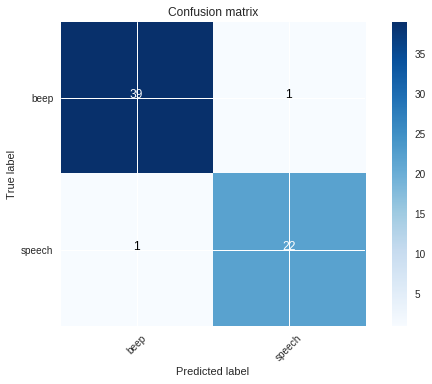

In [7]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
base_lr = LogisticRegression(solver='lbfgs', max_iter=4000)
ovr = OneVsRestClassifier(base_lr)
train(['mfccs_40'], ovr)

In [0]:
save_model(ovr,"ovr")

## RandomForest

total number of features 40
Score: 1.0
cross_val_scores: [0.97275986 0.97275986 1.         1.         1.        ]
Accuracy: 0.99 (+/- 0.03)
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        23

   micro avg       1.00      1.00      1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63

[[40  0]
 [ 0 23]]

Confusion matrix, without normalization
[[40  0]
 [ 0 23]]
*** Scaled ***
scaled_model score: 0.9841269841269841


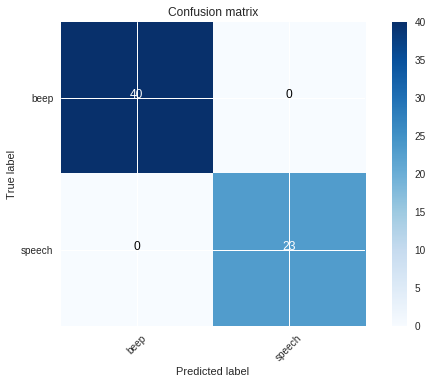

In [8]:
features_to_include = ['mfccs_40']
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 50)
rf = train(features_to_include, model)

In [0]:
#working model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

rf = RandomForestClassifier(n_estimators = 100)
X = list(df.mfccs_40.values)
y = df.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

fit_model = rf.fit(X_train, y_train)

In [0]:
save_model(fit_model,"rf")

## XGBoost

total number of features 40
Score: 0.9682539682539683
cross_val_scores: [0.94602273 0.94492754 0.94345238 0.94070513 0.94393939]
Accuracy: 0.94 (+/- 0.00)
0.9682539682539683
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        40
           1       0.92      1.00      0.96        23

   micro avg       0.97      0.97      0.97        63
   macro avg       0.96      0.97      0.97        63
weighted avg       0.97      0.97      0.97        63

[[38  2]
 [ 0 23]]

Confusion matrix, without normalization
[[38  2]
 [ 0 23]]
*** Scaled ***
scaled_model score: 0.9682539682539683


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

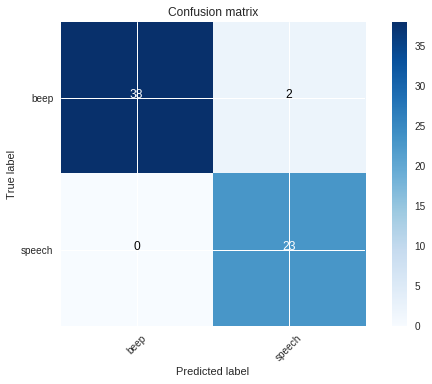

In [9]:
import xgboost as xgb

features_to_include = ['mfccs_40']
model = xgb.XGBClassifier()
train(features_to_include, model)

## LogisticRegression

total number of features 40
Score: 0.9682539682539683
cross_val_scores: [0.94602273 0.94602273 1.         0.97084318 1.        ]
Accuracy: 0.97 (+/- 0.05)
0.9682539682539683
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        40
           1       0.92      1.00      0.96        23

   micro avg       0.97      0.97      0.97        63
   macro avg       0.96      0.97      0.97        63
weighted avg       0.97      0.97      0.97        63

[[38  2]
 [ 0 23]]

Confusion matrix, without normalization
[[38  2]
 [ 0 23]]
*** Scaled ***
scaled_model score: 0.9682539682539683


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

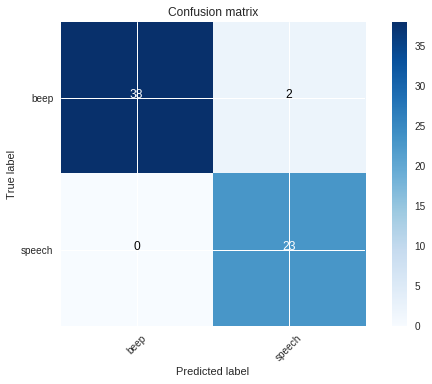

In [10]:
from sklearn.linear_model import LogisticRegression

features_to_include = ['mfccs_40']
logisticRegr = LogisticRegression(solver='liblinear', max_iter=200)
train(features_to_include, logisticRegr)

## SVM

total number of features 40
Score: 0.8412698412698413
cross_val_scores: [0.86759582 0.86759582 0.97275986 0.97164751 1.        ]
Accuracy: 0.94 (+/- 0.11)
0.8412698412698413
              precision    recall  f1-score   support

           0       1.00      0.75      0.86        40
           1       0.70      1.00      0.82        23

   micro avg       0.84      0.84      0.84        63
   macro avg       0.85      0.88      0.84        63
weighted avg       0.89      0.84      0.84        63

[[30 10]
 [ 0 23]]

Confusion matrix, without normalization
[[30 10]
 [ 0 23]]
*** Scaled ***
scaled_model score: 1.0


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

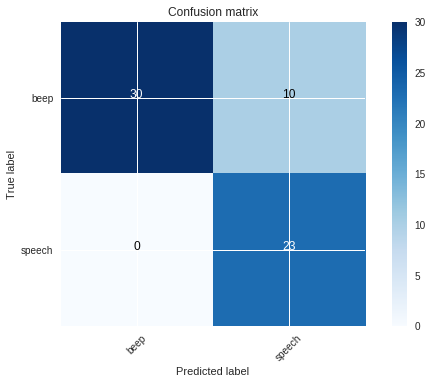

In [11]:
from sklearn import svm
svm = svm.SVC(gamma='scale')
features_to_include = ['mfccs_40']
train(features_to_include, svm)

#Save Model

In [0]:
import pickle
import datetime
filename = "rf-{}.pkl".format(datetime.datetime.now().strftime("%Y%m%dT%H%M"))
pickle.dump(rf, open(filename, 'wb'))